In [8]:
from pathlib import Path
from saffron.io import data_io
from saffron.data import datasets, data_processing
from saffron.models import torch_models
import matplotlib.pyplot as plt

In [2]:
microglia_im_path = "/Users/nelsschimek/Documents/nancelab/Data/Fluorescent_Microglia_Images/nt_control"

In [3]:
images = data_io.load_images_from_directory(microglia_im_path)

INFO:saffron.io.data_io:Successfully loaded 49 images from /Users/nelsschimek/Documents/nancelab/Data/Fluorescent_Microglia_Images/nt_control


In [4]:
ims = data_io.ImageDataset(image_data_list = images)

In [31]:
second_channel_dataset = ims.extract_single_channel(channel=1)

In [32]:
second_channel_dataset[0]

ImageData(data=array([[ 605,  705, 1061, ...,  270,  190,  568],
       [ 578,  567,  713, ...,  390,  392,  402],
       [ 602,  651,  632, ...,  201,  252,  415],
       ...,
       [  11,   44,   31, ...,  282,   72,  115],
       [  88,   21,   12, ...,  351,  132,  170],
       [  37,   95,   14, ...,  358,  227,  340]],
      shape=(512, 512), dtype=uint16), file_path='/Users/nelsschimek/Documents/nancelab/Data/Fluorescent_Microglia_Images/nt_control/4-50-15_40x_thalamus_4.tif', shape=(512, 512), dtype='uint16', metadata={'ImageWidth': 512, 'ImageLength': 512, 'BitsPerSample': 16, 'Compression': <COMPRESSION.NONE: 1>, 'PhotometricInterpretation': <PHOTOMETRIC.MINISBLACK: 1>, 'FillOrder': <FILLORDER.MSB2LSB: 1>, 'ImageDescription': '<?xml version="1.0" encoding="UTF-8"?>\r\n<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2015-01" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2015-01 http://www.openmicrosco

In [38]:
masked_im = data_processing.create_masked_image(second_channel_dataset[17].data, patch_position=(0, 0), patch_size=256)

In [42]:
patch_from_im = data_processing.extract_patch(second_channel_dataset[17].data, patch_position=(0,0), patch_size=256)

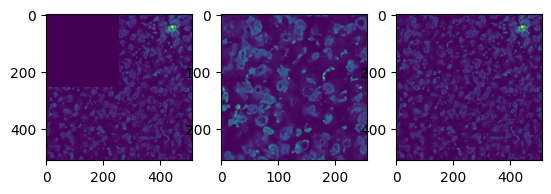

In [52]:
ax, fig = plt.subplots(1,3)
fig[0].imshow(masked_im)
fig[1].imshow(patch_from_im)
fig[2].imshow(second_channel_dataset[17].data)

In [7]:
train_loader, val_loader, test_loader = datasets.create_contrastive_dataloaders(image_directory=microglia_im_path)

INFO:saffron.data.datasets:================================================================================
INFO:saffron.data.datasets:Creating contrastive learning datasets
INFO:saffron.data.datasets:================================================================================
INFO:saffron.data.datasets:
Step 1: Loading images from /Users/nelsschimek/Documents/nancelab/Data/Fluorescent_Microglia_Images/nt_control
INFO:saffron.io.data_io:Successfully loaded 49 images from /Users/nelsschimek/Documents/nancelab/Data/Fluorescent_Microglia_Images/nt_control
INFO:saffron.data.datasets:Loaded 49 images
INFO:saffron.data.datasets:
Step 2: Splitting data using 'random' strategy
INFO:saffron.data.data_processing:Random split: Train=34, Val=5, Test=10
INFO:saffron.data.datasets:Split info: {'train': 34, 'test': 10, 'val': 5, 'total': 49}
INFO:saffron.data.datasets:
Step 3: Generating positive and negative pairs
INFO:saffron.data.datasets:
Processing train split (34 images)...
INFO:saffron.dat

IndexError: list index out of range

In [72]:
model = torch_models.create_model(backbone_type="simple_conv", input_channels=1)

INFO:saffron.models.torch_models:Initialized ContrastiveModel with simple_conv backbone
INFO:saffron.models.torch_models:Encoder output dim: 256
INFO:saffron.models.torch_models:Projection dim: 128


In [73]:
print(f"Parameters: {model.get_num_parameters()}")

# Test forward pass
dummy_input = torch.randn(2, 1, 64, 64)  # Batch of 2, single channel, 64x64
with torch.no_grad():
    features = model.encode(dummy_input)
    projections = model(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Feature shape: {features.shape}")
    print(f"Projection shape: {projections.shape}")

Parameters: {'encoder': 1173600, 'projection_head': 461952, 'total': 461952}


NameError: name 'torch' is not defined